In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### Load data

In [ ]:
adata = sc.read_10x_h5('Donor1_filtered_feature_bc_matrix.h5')

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
adata.var_names_make_unique()
adata # 13330 cells × 33538 genes

AnnData object with n_obs × n_vars = 13330 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [ ]:
sc.pp.filter_genes(adata, min_cells=3) # remove genes not detected in atleast 3 cells

In [ ]:
adata

In [ ]:
adata.X

#### Doublet detection

In [ ]:
import scvi

In [ ]:
# feature selection to reduce training time 

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,      
    flavor='seurat_v3',
    subset=True             # subset adata to HVGs
)

In [ ]:
adata

In [ ]:
scvi.model.SCVI.setup_anndata(adata)
model = scvi.model.SCVI(adata)
model.train()

In [ ]:
solo = scvi.external.SOLO.from_scvi_model(model)
solo.train()

In [ ]:
df = solo.predict() # returns P(cell is a singlet) and P(cell is a doublet)
df['prediction'] = solo.predict(soft = False) # also add prediction class labels
df.head(3)

In [ ]:
df.to_pickle("donor1_solo_out.pkl")

In [ ]:
# df = pd.read_pickle("donor1_solo_out.pkl")

In [ ]:
df['dif'] = df.doublet - df.singlet
df.head(3)

In [ ]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif') 

In [ ]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.5)]
doublets.head(3)

#### Reload adata

In [2]:
# Because we reduced adata to only the top highly variable genes (HVGs) before training scVI
adata = sc.read_10x_h5('Donor2_filtered_feature_bc_matrix.h5') 

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 13330 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
adata.obs.head(3)


""
AAACCCAAGACTGAGC-1
AAACCCAAGGTTACCT-1
AAACCCAAGTGGATAT-1


In [ ]:
adata.obs['doublet_prediction'] = adata.obs.index.isin(doublets.index)
adata.obs.head(3)

In [ ]:
# only flagged cells as doublet or singlet for now.
# to remove use:
# adata = adata[~adata.obs.doublet]

#### Calculate Quality Control Covariates

In [6]:
# define mitochondrial and ribosomal genes

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

adata.var.head(3)

,gene_ids,feature_types,genome,mt,ribo
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False


In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False, percent_top=None
)

In [ ]:
adata.obs.head(3)

#### Key Quality Control Metrics

- **n_genes_by_counts** — Number of genes expressed in the count matrix.  
- **total_counts** — Total counts per cell.  
- **pct_counts_mt** — Percentage of counts in mitochondrial genes.  


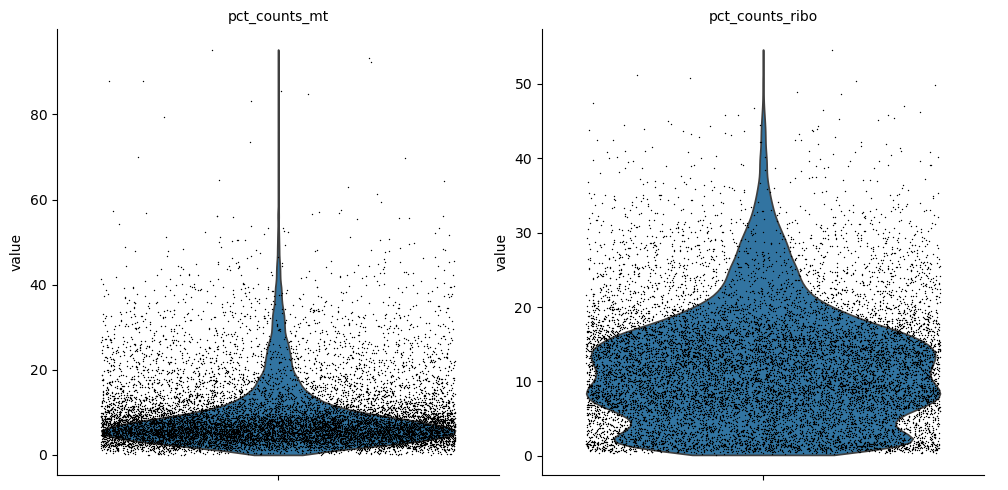

In [8]:
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

In [ ]:

total_counts = adata.obs['total_counts']
n_genes = adata.obs['n_genes_by_counts']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(total_counts, bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Total Counts per Cell')
axes[0].set_xlabel('Total Counts')
axes[0].set_ylabel('Number of Cells')

axes[1].hist(n_genes, bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Number of Genes per Cell')
axes[1].set_xlabel('Number of Genes')
axes[1].set_ylabel('Number of Cells')

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'])
axes[0].set_xlabel('Total Counts')
axes[0].set_ylabel('Number of Genes by Counts')
axes[0].set_title('n_genes_by_counts vs Total Counts')

axes[1].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], color='red')
axes[1].set_xlabel('Total Counts')
axes[1].set_ylabel('Percentage of Mitochondrial Counts')
axes[1].set_title('pct_counts_mt vs Total Counts')

plt.tight_layout()
plt.show()

In [ ]:
# sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

ax = sc.pl.scatter(
    adata, 
    "total_counts", 
    "n_genes_by_counts", 
    color="pct_counts_mt", 
    show=False
)
ax.axvline(x=80000, color="red", linestyle="--", linewidth=1)
ax.axhline(y=9000, color="blue", linestyle="--", linewidth=1)

plt.show()

In [ ]:
adata.obs.sort_values(by='n_genes_by_counts', ascending=True).head(3)

In [ ]:
adata.obs.sort_values(by='total_counts', ascending=True).head(3)

In [ ]:
# applying same filter used before doublet detection
sc.pp.filter_genes(adata, min_cells=3) 

In [ ]:
# filter cells with tptal_counts > 80k
sc.pp.filter_cells(adata, max_counts=80000)

In [ ]:
# filter cells with mito and ribo fraction >= 20
adata = adata[adata.obs.pct_counts_mt < 20]
adata = adata[adata.obs.pct_counts_ribo < 20]

In [ ]:
adata

#### Normalization

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
sc.pp.log1p(adata)

In [ ]:
adata_copy = adata.copy()

In [ ]:
adata_copy

#### Feature selection

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
adata.var.head(3) # new column - highly_variable 

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata = adata[:, adata.var.highly_variable] # only keep highly variable genes
adata

#### Dimensionality reduction and clustering

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [ ]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [ ]:
sc.pl.umap(adata, color=["leiden"])

In [ ]:
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "doublet_prediction"],
)

#### without feature selection

In [ ]:
sc.tl.pca(adata_copy, svd_solver='arpack')
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)
sc.tl.leiden(adata_copy)

In [ ]:
sc.pl.umap(adata_copy, color=["leiden"])

In [ ]:
# adata.write("adata.h5ad")
# adata = sc.read_h5ad("adata.h5ad")